# Knowledge Assembly

In [1]:
from network import Network
from helpers import fit_sigmoid, mean_squared_error, rotate, load_behavioural_data
from plotting import plotting_init, matrix_plot, mds_plot

import torch
import numpy as np
from scipy.special import expit
from sklearn import manifold
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool

## Load behavioural data

In [2]:
midd_performance, high_performers, low_performers = load_behavioural_data("./behavioural-data/")

## Set simulation mode

In [3]:
mode = "main" # "lazy-regime", "two-readouts", "fixed-inputs"

## Set Hyperparameters

In [4]:
# Random seeds
seeds_n = 20
mds_seed = 1

# Number of input items
items_n = 12

# Experiment details
training_blocks = 16 if mode == "two-readouts" else 8
trials = 60
training_length = 2 * training_blocks * trials
stitching_steps = 20

# Network hyperparameters
readouts = 2 if mode == "two-readouts" else 1
h1_size = 20

if mode == "lazy-regime":
    w1_weight_std = np.sqrt(6. / items_n)
    w2_weight_std = np.sqrt(10. / h1_size)
else:
    w1_weight_std = 0.025 * np.sqrt(1 / items_n)
    w2_weight_std = np.sqrt(1 / h1_size)

learning_rate = 0.03 if mode == "lazy-regime" else 0.05

# Parameter space for gridsearch
gammas = np.concatenate([[0], np.geomspace(1e-4, 1, 69)])
ss = np.geomspace(1e-2, 100, 65)

## Train Networks

In [5]:
def train_networks(gamma):
    # Log
    results = {
        "train": {
            "losses": np.zeros((seeds_n, training_length)),
            "w1s": np.zeros((seeds_n, training_length, h1_size, items_n)),
            "w2s": np.zeros((seeds_n, training_length, readouts, h1_size)),
            "h1s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "certainties": np.zeros((seeds_n, training_length, items_n, items_n)),
            "evals": np.zeros((seeds_n, items_n, items_n)),
        },
        "stitch": {
            "losses": np.zeros((seeds_n, stitching_steps)),
            "w1s": np.zeros((seeds_n, stitching_steps, h1_size, items_n)),
            "w2s": np.zeros((seeds_n, stitching_steps, readouts, h1_size)),
            "certainties": np.zeros((seeds_n, stitching_steps, items_n, items_n)),
            "h1s": np.zeros((seeds_n, stitching_steps, items_n, h1_size)),
            "evals": np.zeros((seeds_n, items_n, items_n)),
        }
    }
    
    if gamma == 0.:
        results["train"]["training_progress"] = np.zeros((seeds_n, training_length, items_n, items_n))
    
    for seed in range(seeds_n):
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Init Network
        model = Network(items_n, h1_size, w1_weight_std, w2_weight_std, readouts=readouts)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

        training_step = 0
        items_per_context = items_n // 2
        
        for block in range(training_blocks):
            training_pairs = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
            for context in range(2):
                training_pairs += context * items_per_context
                for trial in range(trials):
                    # Sample input and target
                    random_index = np.random.randint(0, len(training_pairs))
                    item_1, item_2 = np.random.choice(training_pairs[random_index], 2, False)
                    if readouts == 1:
                        target = torch.tensor([1. if item_1 > item_2 else -1.])
                    elif readouts == 2:
                        target = torch.tensor([1., -1.] if item_1 > item_2 else [-1., 1.])

                    # Forward propagate and backpropagate
                    optimiser.zero_grad()
                    _, output = model(item_1, item_2)
                    model.loss = criterion(output, target)
                    model.loss.backward()
                    model.correct(learning_rate, gamma)
                    optimiser.step()

                    # Log
                    with torch.no_grad():
                        results["train"]["losses"][seed, training_step] = model.loss.item()
                        results["train"]["w1s"][seed, training_step] = model.layer_1.weight.detach().numpy().copy()
                        results["train"]["w2s"][seed, training_step] = model.layer_2.weight.detach().numpy().copy()
                        results["train"]["h1s"][seed, training_step] = model.extract_h1s()
                        results["train"]["certainties"][seed, training_step] = model.pairwise_certainty.a.copy()
                        if gamma == 0.:
                            results["train"]["training_progress"][seed, training_step] = model.evaluate()
                    
                    training_step += 1
        
        # Evaluate
        with torch.no_grad():
            results["train"]["evals"][seed] = model.evaluate()

        # Stitching
        for stitching_step in range(stitching_steps):
            # Select items from boundary condition
            item_1, item_2 = np.random.choice([(items_n // 2) - 1, (items_n // 2)], 2, replace=False)
            if readouts == 1:
                target = torch.tensor([1. if item_1 > item_2 else -1.])
            elif readouts == 2:
                target = torch.tensor([1., -1.] if item_1 > item_2 else [-1., 1.])
                

            # Forward propagate and backpropagate
            optimiser.zero_grad()
            h1, output = model(item_1, item_2)
            model.loss = criterion(output, target)
            model.loss.backward()
            model.correct(learning_rate, gamma)
            
            if mode == "fixed-inputs":
                model.layer_1.weight.grad *= 0.
            
            optimiser.step()
            
            # Log
            with torch.no_grad():
                results["stitch"]["losses"][seed, stitching_step] = model.loss.item()
                results["stitch"]["w1s"][seed, stitching_step] = model.layer_1.weight.detach().numpy().copy()
                results["stitch"]["w2s"][seed, stitching_step] = model.layer_2.weight.detach().numpy().copy()
                results["stitch"]["h1s"][seed, stitching_step] = model.extract_h1s()
                results["stitch"]["certainties"][seed, stitching_step] = model.pairwise_certainty.a.copy()

        # Evaluate
        with torch.no_grad():
            results["stitch"]["evals"][seed] = model.evaluate()
        
    return gamma, results
    

with Pool(20) as p:
    results = p.map(train_networks, gammas)
results = {gamma: result for gamma, result in results}

## Perform gridsearch to find optimal hyperparameters

In [6]:
mse_grids = []
for i, performer in enumerate([low_performers, high_performers]):
    mse_grid = np.zeros((len(gammas), len(ss)))
    for j, gamma in enumerate(gammas):
        for k, s in enumerate(ss):
            mses = np.zeros(seeds_n)
            for seed in range(seeds_n):
                fitted = expit(s * results[gamma]["stitch"]["evals"][seed])
                mses[seed] = mean_squared_error(fitted, performer, True)
            mse_grid[j, k] = np.mean(mses)
    mse_grids.append(mse_grid)

optimal_values = {
    "low_performers": {"pos_x": [], "pos_y": [], "gamma": [], "s": []},
    "high_performers": {"pos_x": [], "pos_y": [], "gamma": [], "s": []}
}

for mode, mse_grid in zip(["low_performers", "high_performers"], mse_grids):
    for threshold in [1., 0.5]:
        pos_y, pos_x = np.unravel_index(mse_grid[gammas < threshold, :].argmin(), mse_grid.shape)
        optimal_values[mode]["pos_x"].append(pos_x)
        optimal_values[mode]["s"].append(ss[pos_x])
        optimal_values[mode]["pos_y"].append(pos_y)
        optimal_values[mode]["gamma"].append(gammas[pos_y])

sgd = 0.
stitchers = optimal_values["high_performers"]["gamma"][0]
non_stitchers = optimal_values["low_performers"]["gamma"][0]

print(optimal_values)

{'low_performers': {'pos_x': [32, 34], 'pos_y': [68, 23], 'gamma': [0.8733261623828429, 0.0019684194472866113], 's': [1.0, 1.333521432163324]}, 'high_performers': {'pos_x': [43, 43], 'pos_y': [53, 53], 'gamma': [0.11450475699382812, 0.11450475699382812], 's': [4.869675251658631, 4.869675251658631]}}


## Create plots

In [7]:
blue, blue2, red, red2, magma_3 = plotting_init()

### Network output and choice matrix

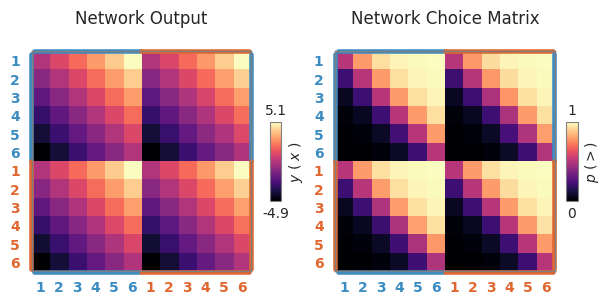

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4), constrained_layout=True)
fig.patch.set_facecolor('white')

evaluation = np.mean(results[sgd]["train"]["evals"], axis=0)
current_cmap = plt.cm.get_cmap("magma")
current_cmap.set_bad(color=[0.95]*3)

vmin, vmax = np.round(np.min(evaluation), 1),np.round(np.max(evaluation), 1)
im = matrix_plot(evaluation, axs[0], items_n)
cbar = fig.colorbar(im, ax=axs[0], anchor=(0., 0.5), shrink=.2, aspect=7.)
cbar.set_ticks([])
cbar.ax.text(0.5, vmax*1.3, vmax, ha='center', va='center')
cbar.ax.text(0.5, vmin*1.35, vmin, ha='center', va='center')
cbar.set_label("$y\ (\ x\ )$")
cbar.outline.set_edgecolor([0.5] * 3)
axs[0].set_title("Network Output", pad=20.)

s = fit_sigmoid(evaluation, midd_performance, initial_s=.1, exclude_diagonal=True)
fit = expit(s * evaluation)

im = matrix_plot(fit, axs[1], items_n, 0, 1)
cbar = fig.colorbar(im, ax=axs[1], anchor=(0., 0.5), shrink=.2, aspect=7.)
cbar.set_ticks([])
cbar.ax.text(0.5, 1.15, 1, ha='center', va='center')
cbar.ax.text(0.5, -0.17, 0, ha='center', va='center')
cbar.set_label("$p\ (>)$")
cbar.outline.set_edgecolor([0.5] * 3)
axs[1].set_title("Network Choice Matrix", pad=20.);

### Test accuracy

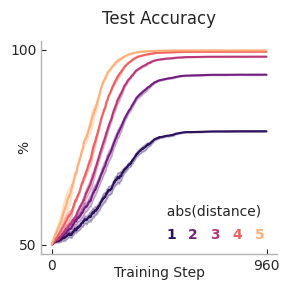

In [9]:
means = np.mean(results[sgd]["train"]["training_progress"], axis=0)
progresses = [[] for _ in range(6)]
for distance in range(6):
    for item_1 in range(6):
        for item_2 in range(6):
            if item_2 - item_1 == distance:
                for x_offset in [0, 6]:
                    for y_offset in [0, 6]:
                        progresses[distance].append(means[:, item_1 + x_offset, item_2 + y_offset])

fig, ax = plt.subplots(figsize=(3, 3))
fig.patch.set_facecolor('white')
colors = []
for distance in range(1, 6):
    color = plt.cm.magma(distance / 6.)
    colors.append(color)
    progress = expit(s * np.asarray(progresses[distance]))
    mean = np.mean(progress, axis=0)
    sem = np.std(progress, axis=0) / np.sqrt(progress.shape[0])
    ax.plot(mean, color=color, label=distance)
    ax.fill_between(range(len(mean)), mean - sem, mean + sem, color=color, alpha=0.3)
ax.set_yticks([0.5, 1.])
ax.set_yticklabels([50, 100])
ax.set_xticks([0., 960.])
ax.set_title("Test Accuracy", pad=12.)
ax.set_xlabel("Training Step", labelpad=-5.)
ax.set_ylabel("%", labelpad=-15.)

for pos in ["left", "bottom"]:
    ax.spines[pos].set_linewidth(1)
    ax.spines[pos].set_color([0.7]*3)

    ax.legend(title="  abs(distance)", prop={"weight": "bold"}, ncol=6, frameon=False, handlelength=0,
              columnspacing=0.1, labelspacing=0.65, labelcolor=colors)
sns.despine()
fig.tight_layout()

## RDMs and MDSs

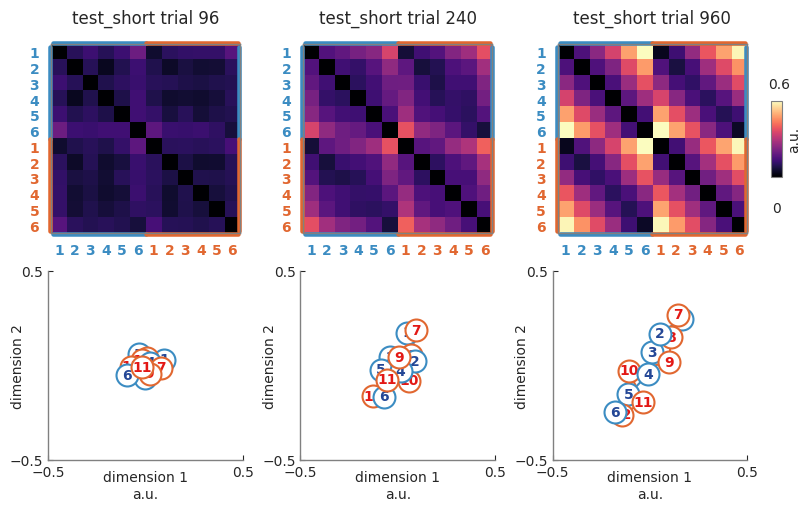

In [10]:
positions = [.1, .25, 1.]

fig, axs = plt.subplots(2, 3, figsize=(8., 5), constrained_layout=True)
fig.patch.set_facecolor('white')

# Extraxt maximum euclidean distance
all_h1s = np.mean(results[sgd]["train"]["h1s"], axis=0)

steps_after_training = all_h1s.shape[0] - 1

# Plot euclidean distances
vmax = 0.
for i in range(3):
    h1s = all_h1s[int(positions[i] * steps_after_training)]
    vmax_ = np.round(np.max(euclidean_distances(h1s)), 1)
    if vmax_ > vmax:
        vmax = vmax_

for i in range(3):
    h1s = all_h1s[int(positions[i] * steps_after_training)]
    im = matrix_plot(euclidean_distances(h1s), axs[0, i], items_n, 0., vmax)
    axs[0, i].set_title(f"test_short trial {int(positions[i] * steps_after_training) + 1}", pad=15)

cbar = fig.colorbar(im, ax=axs[0, i], anchor=(0., 0.5), shrink=.4, aspect=7.)
cbar.set_ticks([])
cbar.ax.text(.7, vmax*1.22, vmax, ha='center', va='center')
cbar.ax.text(.5, -0.25, 0, ha='center', va='center')
cbar.set_label("a.u.")
cbar.outline.set_edgecolor([0.5] * 3)

# Plot MDSs
for i in range(3):
    distances = euclidean_distances(all_h1s[int(positions[i] * steps_after_training)])
    mds = manifold.MDS(n_components=2, eps=1e-9, dissimilarity="precomputed", random_state=mds_seed,
                       normalized_stress="auto")
    d1, d2 = mds.fit(distances).embedding_.T

    if i == 0:
        rotate(d1, d2, 250.)
    if i == 1:
        rotate(d1, d2, 230.)
    else:
        rotate(d1, d2, 260.)

    mds_plot((d1, d2), axs[1, i], items_n)

    lim = 0.50
    axs[1, i].set_xlim(-lim, lim)
    axs[1, i].set_ylim(-lim, lim)
    axs[1, i].set_xticks([-0.5, 0.5])
    axs[1, i].set_yticks([-0.5, 0.5])
    
    # Set border color
    for pos in ["left", "bottom"]:
        axs[1, i].spines[pos].set_linewidth(1)
        axs[1, i].spines[pos].set_color([0.5]*3)

    axs[1, i].set_xlabel("dimension 1\na.u.", labelpad=-6.)
    axs[1, i].set_ylabel("dimension 2", labelpad=-11.)

## RDMs and MDSs after train short and train long

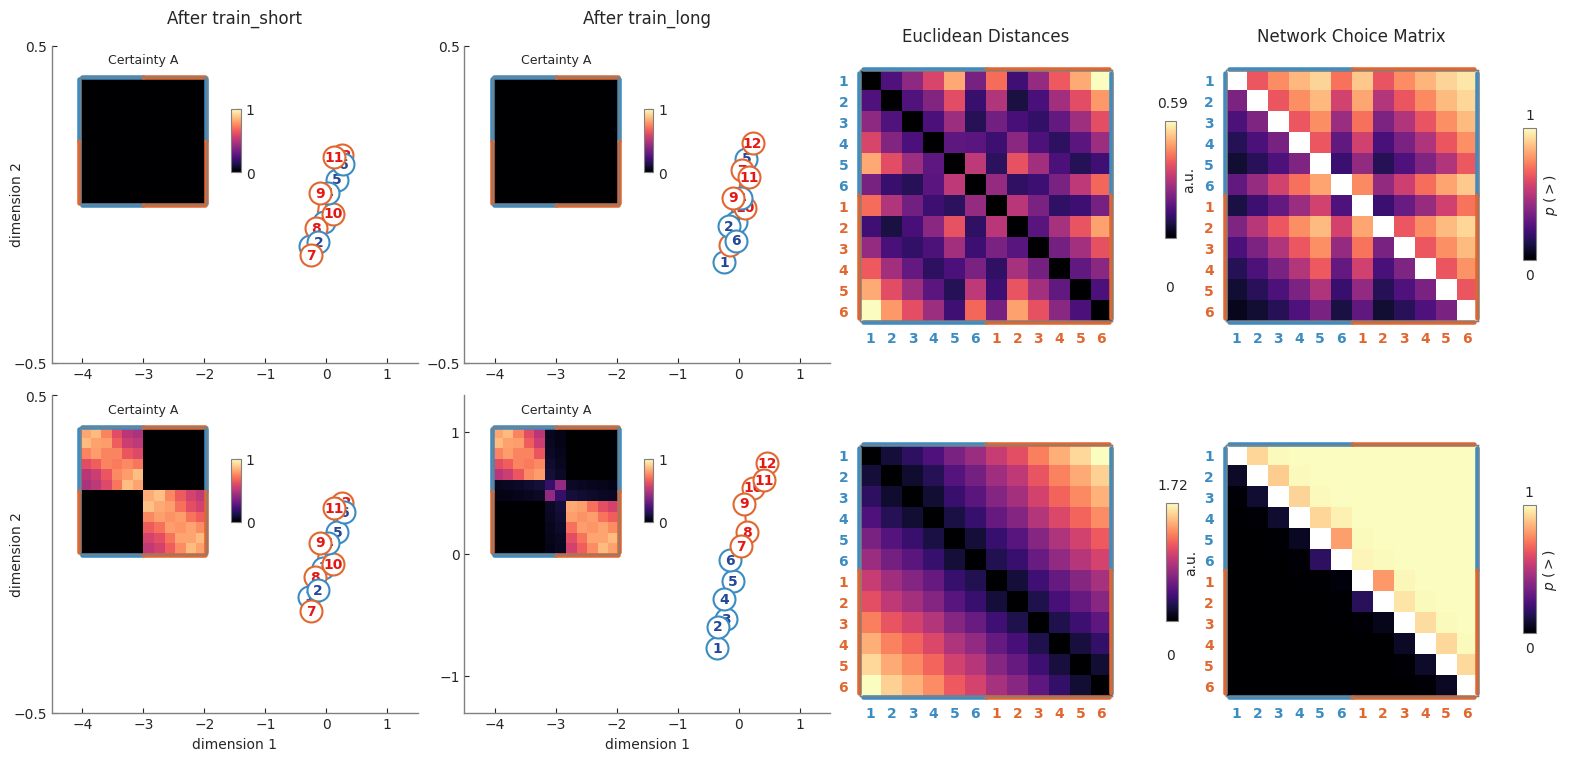

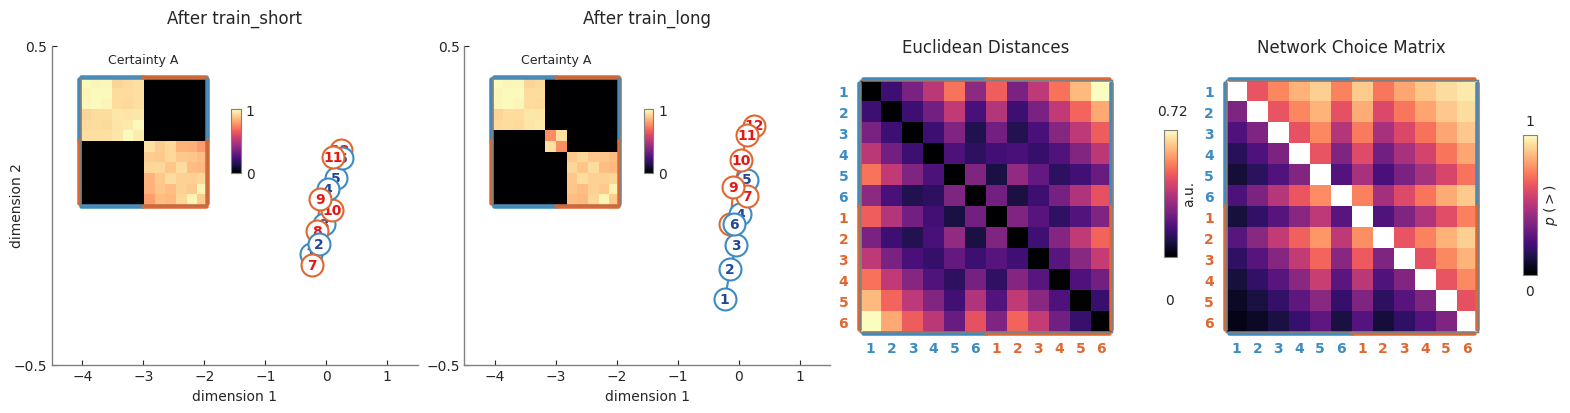

In [11]:
fig1, axs1 = plt.subplots(2, 4, figsize=(13*1.2, 6.25*1.2), constrained_layout=True)
fig1.patch.set_facecolor('white')
fig2, axs2 = plt.subplots(1, 4, figsize=(13*1.2, 3.35*1.2), constrained_layout=True)
fig2.patch.set_facecolor('white')

for i, key in enumerate([sgd, stitchers, non_stitchers]):
    if i < 2:
        axs = axs1
    else:
        axs = axs2.reshape(1, -1)
        i = 0
    
    # MDS
    for k, timepoint in enumerate(["train", "stitch"]):
        h1s = np.mean(np.asarray(results[key][timepoint]["h1s"]), 0)[-1]
        distances = euclidean_distances(h1s)
        mds = manifold.MDS(n_components=2, eps=1e-9, dissimilarity="precomputed", random_state=mds_seed,
                           normalized_stress="auto")
        d1, d2 = mds.fit(distances).embedding_.T
        
        
        
        if mode == "two-readouts":
            if i == 0:
                if k == 0:
                    rotate(d1, d2, 50.) if axs is axs1 else rotate(d1, d2, 55.)
                else:
                    rotate(d1, d2, 70.) if axs is axs1 else rotate(d1, d2, 35.)
            else:
                if k == 0:
                    rotate(d1, d2, 120.)
                else:
                     rotate(d1, d2, 340.)

            mds_plot((d1, d2), axs[i, k], items_n)

            axs[i, k].set_xlim(-2.05, 1.)
            axs[i, k].set_ylim(-.55, .55)
            axs[i, k].set_yticks([-0.5, 0., 0.5])
            if i == 1 and k == 1:
                axs[i, k].set_ylim(-1.1, 1.1)
                axs[i, k].set_yticks([-1, 0, 1])
        
        else:
            if i == 0:
                if k == 0:
                    rotate(d1, d2, 50.) if axs is axs1 else rotate(d1, d2, 55.)
                else:
                    rotate(d1, d2, 140.) if axs is axs1 else rotate(d1, d2, 50.)
            else:
                if k == 0:
                    rotate(d1, d2, 50.)
                else:
                     rotate(d1, d2, 40.)

            mds_plot((d1, d2), axs[i, k], items_n)

            axs[i, k].set_xlim(-4.5, 1.5)
            axs[i, k].set_ylim(-.5, .5)
            axs[i, k].set_yticks([-0.5, 0.5])
            if i == 1 and k == 1:
                axs[i, k].set_ylim(-1.3, 1.3)
                axs[i, k].set_yticks([-1, 0, 1])
            
    # Set border color
    for pos in ["left", "bottom"]:
        for n in range(2):
            axs[i, n].spines[pos].set_linewidth(1)
            axs[i, n].spines[pos].set_color([0.5]*3)
    
    axs[0, 0].set_title("After train_short", pad=16.)
    axs[0, 1].set_title("After train_long", pad=16.)
    for n in range(2):
        if (axs.shape[0] == 2 and i == 1) or axs.shape[0] == 1:
            axs[i, n].set_xlabel("dimension 1")
        axs[i, 0].set_ylabel("dimension 2", labelpad=-7.5)
        
    
    # Certainty matrices
    for k, timepoint in enumerate(["train", "stitch"]):
        ins = axs[i, k].inset_axes([0.05, 0.5, 0.4, 0.4])
        certainties = np.mean(results[key][timepoint]["certainties"], axis=0)[-1]
        im = matrix_plot(certainties, ins, items_n, 0., 1.)
        ins.set_xticks([])
        ins.set_yticks([])
        ins.set_title("Certainty A", fontsize=9., pad=10)
        
        ins = axs[i, k].inset_axes([0.49, 0.6, 0.027, 0.2])
        cbar = fig.colorbar(im, cax=ins, orientation='vertical')
        cbar.set_ticks([0, 1])
        cbar.outline.set_edgecolor([0.5] * 3)
    
    sns.despine(ax=axs[i, 0])
    sns.despine(ax=axs[i, 1])
    

    # Euclidean Distances
    h1s = np.mean(results[key]["stitch"]["h1s"], 0)[-1]
    distances = euclidean_distances(h1s)
    
    im = matrix_plot(distances, axs[i, 2], items_n, 0, np.max(distances))
    shrink, aspect = (0.4, 10)
    cbar = fig.colorbar(im, ax=axs[i, 2], anchor=(0., 0.5), shrink=shrink, aspect=aspect)
    cbar.set_ticks([])
    vmax = np.round(np.max(distances), 2)
    if i == 0:
        cbar.ax.text(.4, -0.25, 0, ha='center', va='center')
        cbar.ax.text(.65, vmax * 1.15, vmax, ha='center', va='center')
    if i == 1:
        cbar.ax.text(0.3, -0.5, 0, ha='center', va='center')
        cbar.ax.text(0.5, vmax * 1.15, vmax, ha='center', va='center')
    cbar.set_label("a.u.")
    cbar.outline.set_edgecolor([0.5] * 3)
    
    axs[0, 2].set_title("Euclidean Distances", pad=20.)

    # Network Choice Matrix
    behaviour = high_performers if i == 1 else low_performers
    evals = np.mean(results[key]["stitch"]["evals"], 0)
    s = fit_sigmoid(evals, behaviour, initial_s=0.01, exclude_diagonal=True)
    fit = expit(s * evals)
    np.fill_diagonal(fit, np.nan)

    im = matrix_plot(fit, axs[i, 3], items_n, 0, 1)
    cbar = fig.colorbar(im, ax=axs[i, 3], anchor=(0., 0.5), shrink=shrink, aspect=aspect)
    cbar.set_ticks([])
    cbar.ax.text(0.5, 1.1, 1, ha='center', va='center')
    cbar.ax.text(0.5, -0.12, 0, ha='center', va='center')
    cbar.set_label("$p\ (>)$")
    cbar.outline.set_edgecolor([0.5] * 3)

    axs[0, 3].set_title("Network Choice Matrix", pad=20.);

## Performance after train short for different gammas

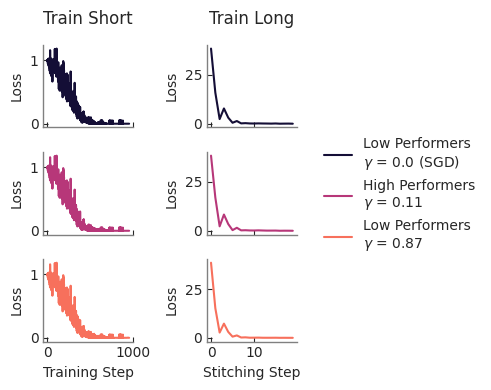

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(3.3, 4))
fig.patch.set_facecolor('white')

sgd_train_loss = np.mean(results[sgd]["train"]["losses"], axis=0)
sgd_stitch_loss = np.mean(results[sgd]["stitch"]["losses"], axis=0)
for n, (gamma, label) in enumerate(zip([sgd, stitchers, non_stitchers], ["Low Performers", "High Performers", "Low Performers"])):
    post = "" if gamma != 0. else " (SGD)"
    label = f"{label}\n$\gamma$ = {np.round(gamma, 2)}" + post
    axs[n, 0].plot(np.mean(results[gamma]["train"]["losses"], axis=0), color=magma_3[n])
    axs[n, 1].plot(np.mean(results[gamma]["stitch"]["losses"], axis=0), color=magma_3[n], label=label)
    
    if n < 2:
        axs[n, 0].set_xticklabels([])
        axs[n, 1].set_xticklabels([])
    
    for i in range(2):
        axs[n, i].set_ylabel("Loss")
    
    for pos in ["left", "bottom"]:
        for i in range(2):
            axs[n, i].spines[pos].set_linewidth(1)
            axs[n, i].spines[pos].set_color([0.5]*3)

axs[0, 0].set_title("Train Short", pad=15)
axs[0, 1].set_title("Train Long", pad=15)

axs[2, 0].set_xlabel("Training Step")
axs[2, 1].set_xlabel("Stitching Step")

box = axs[2, 1].get_position()
axs[2, 1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0.)


# Set border color
sns.despine()
fig.tight_layout()

## Fits for s and MSE for vairous values of gamma

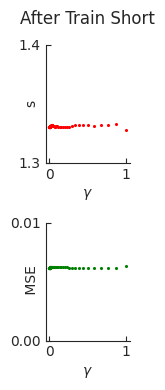

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(1.5, 4))
fig.patch.set_facecolor('white')
for gamma in gammas:
    evaluation = np.mean(results[gamma]["train"]["evals"], axis=0)
    s = fit_sigmoid(evaluation, midd_performance, initial_s=.1, exclude_diagonal=True)
    axs[0].scatter(gamma, s, color="red", s=1.5)
    axs[0].set_ylim(1.3, 1.4)
    axs[0].set_yticks([1.3, 1.4])
    axs[0].set_ylabel("s", labelpad=-14)
    axs[0].set_xlabel("$\gamma$")
    
    fit = expit(s * evaluation)
    mse = mean_squared_error(fit, midd_performance, exclude_diagonal=True)
    axs[1].scatter(gamma, mse, color="green", s=1.5)
    axs[1].set_ylim(0., .01)
    axs[1].set_yticks([0., .01])
    axs[1].set_xticks([0., 1.])
    axs[1].set_ylabel(" MSE", labelpad=-21.)
    axs[1].set_xlabel("$\gamma$")

axs[0].set_title("After Train Short", pad=15)

sns.despine()
fig.tight_layout()

## Grid search and optimal parameters

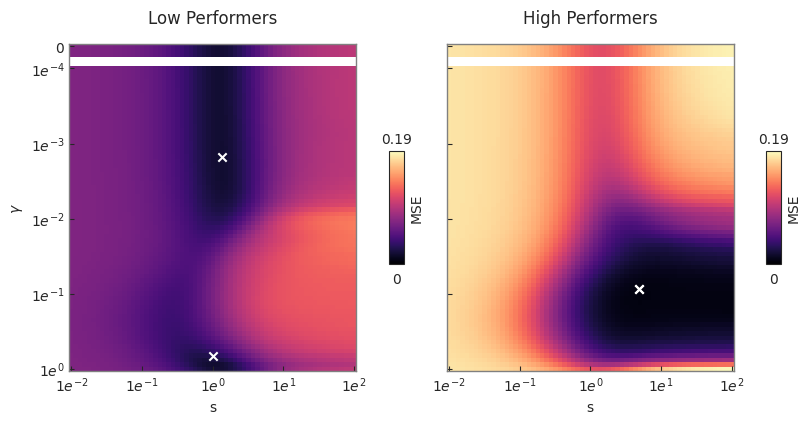

In [14]:
zero_repeat = 2
zero_offset = 2
vmax = np.round(np.max(mse_grids), 2)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 5), constrained_layout=True)
fig.patch.set_facecolor('white')

for i, (mode, mse_grid) in enumerate(zip(["low_performers", "high_performers"], mse_grids)):    
    mse_grid = np.insert(mse_grid, [1] * (zero_offset + zero_repeat), np.nan, axis=0)
    for j in range(zero_repeat):
        mse_grid[j + 1, :] = mse_grid[0, :]
    im = axs[i].imshow(mse_grid, vmin=0., vmax=vmax, cmap=plt.cm.magma)
    
    for pos_x, pos_y in zip(optimal_values[mode]["pos_x"], optimal_values[mode]["pos_y"]):
        axs[i].scatter(pos_x, pos_y + zero_offset, c="w", marker="x")
    
    axs[i].set_xticks([16 * i for i in range(5)])
    axs[i].set_xticklabels(["$1e^{" + str(i) + "}$" for i in range(-2, 3)])
    axs[i].set_xlabel("s")

    for pos in ["top", "right", "bottom", "left"]:
        axs[i].spines[pos].set_linewidth(1.)
        axs[i].spines[pos].set_color([0.5]*3)

    cbar = fig.colorbar(im, ax=axs[i], shrink=0.23, aspect=7.6)
    cbar.set_ticks([])
    cbar.ax.text(0.5, -0.025, 0, ha='center', va='center')
    cbar.ax.text(0.5, vmax * 1.1, vmax, ha='center', va='center')
    cbar.set_label("MSE")

axs[0].set_title("Low Performers", pad=15.)
axs[1].set_title("High Performers", pad=15.)

axs[0].set_yticks([0] + [zero_repeat + zero_offset + 1 + 17 * i for i in range(5)])
axs[0].set_yticklabels(["0"] + ["$1e^{" + str(i) + "}$" for i in range(-4, 1)])
axs[0].set_ylabel("$\gamma$");

## Difference between fits

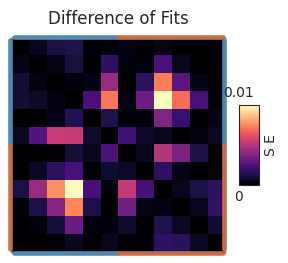

In [15]:
optimal_gamma_1 = optimal_values["low_performers"]["gamma"][0]
optimal_gamma_2 = optimal_values["low_performers"]["gamma"][1]
optimal_s_1 = optimal_values["low_performers"]["s"][0]
optimal_s_2 = optimal_values["low_performers"]["s"][1]

eval_1 = np.mean(results[optimal_gamma_1]["stitch"]["evals"], 0)
eval_2 = np.mean(results[optimal_gamma_2]["stitch"]["evals"], 0)

fit1 = expit(optimal_s_1 * eval_1)
fit2 = expit(optimal_s_2 * eval_2)

squared_difference = (fit1 - fit2)**2

vmax = np.round(np.max(squared_difference), 2)

fig, ax = plt.subplots(figsize = (3., 3.))
fig.patch.set_facecolor('white')

im = matrix_plot(squared_difference, ax, items_n, 0, vmax)


cbar = fig.colorbar(im, ax=ax, shrink=.3, aspect=4.)
cbar.set_ticks([])
cbar.ax.text(0.0055, -0.0015, 0, ha='center', va='center')
cbar.ax.text(0.006, vmax * 1.15, vmax, ha='center', va='center')
cbar.set_label("S E")

ax.set_xticks([])
ax.set_yticks([])

ax.set_title("Difference of Fits", pad=10)
fig.tight_layout()